Year 2021: 186 abstracts loaded
Year 2022: 233 abstracts loaded
Year 2023: 318 abstracts loaded
Year 2024: 279 abstracts loaded
Total filtered terms: 929
Filtered terms: ['improvement', 'specifically', 'terms', 'error analysis', 'natural language', 'mainly', 'sub', 'code available', 'real', 'detection persuasion']
Year 2021: 764 terms
Terms: [('10', 1), ('11', 1), ('12', 1), ('14', 1), ('16', 1), ('1st', 1), ('20', 1), ('22', 1), ('2nd', 1), ('3rd', 1)]
Year 2022: 843 terms
Terms: [('10', 1), ('10th', 1), ('11', 1), ('11th', 1), ('12', 1), ('14', 1), ('16', 1), ('1st', 1), ('22', 1), ('25', 1)]
Year 2023: 893 terms
Terms: [('10', 1), ('10th', 1), ('11', 1), ('11th', 1), ('12', 1), ('14', 1), ('16', 1), ('1st', 1), ('20', 1), ('22', 1)]
Year 2024: 841 terms
Terms: [('10', 1), ('10th', 1), ('11th', 1), ('12', 1), ('14', 1), ('1st', 1), ('20', 1), ('22', 1), ('25', 1), ('2nd', 1)]
Total trends: 929
Sample trends: [('improvement', [(2022, 0), (2023, 0), (2024, 0)]), ('specifically', [(2022

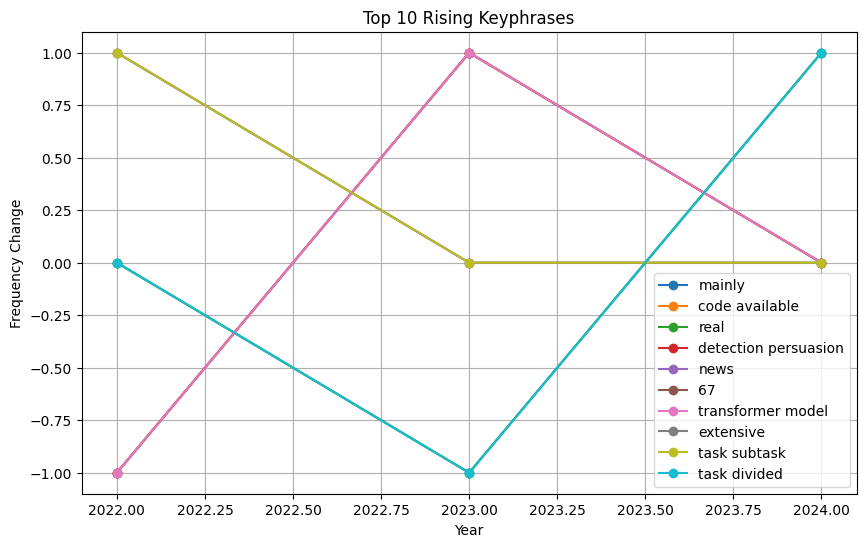

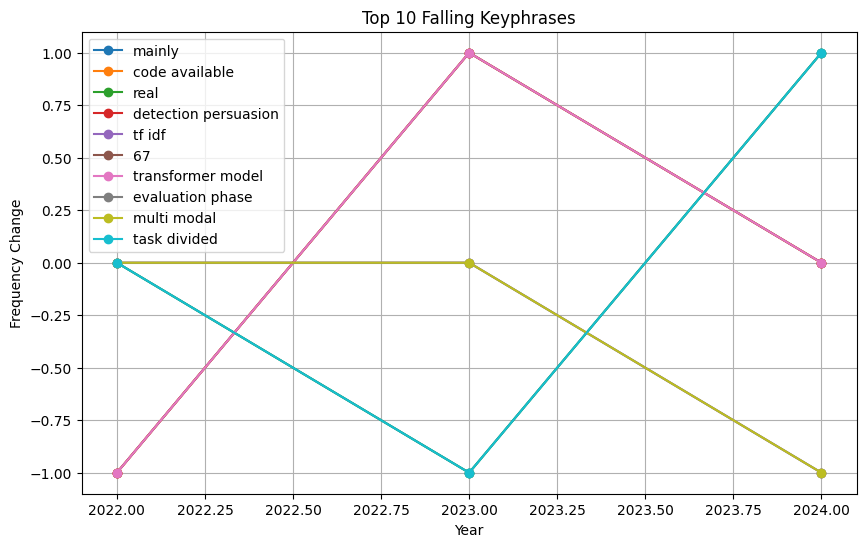

In [6]:
import json
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Define the files and their associated years
file_year_mapping = {
    "papers-semeval-2021.json": 2021,
    "papers-semeval-2022.json": 2022,
    "papers-semeval-2023.json": 2023,
    "papers-semeval-2024.json": 2024,
}

# Load stopwords from stopwords.txt
with open("stopwords.txt", "r", encoding="utf-8") as f:
    file_stopwords = set(line.strip().lower() for line in f)

# Group abstracts by year
abstracts_by_year = defaultdict(list)
for file, year in file_year_mapping.items():
    with open(file, "r", encoding="utf-8") as f:
        papers = json.load(f)
        abstracts = [paper["abstract"] for paper in papers if paper.get("abstract")]
        abstracts_by_year[year] = abstracts

# Verify loaded abstracts
for year, abstracts in abstracts_by_year.items():
    print(f"Year {year}: {len(abstracts)} abstracts loaded")

# Dynamic stopwords to exclude overly common terms
def generate_dynamic_stopwords(abstracts_by_year):
    term_frequencies = defaultdict(int)
    total_abstracts = sum(len(abstracts) for abstracts in abstracts_by_year.values())
    for abstracts in abstracts_by_year.values():
        for abstract in abstracts:
            for term in set(re.findall(r'\b[a-zA-Z][a-zA-Z]+\b', abstract.lower())):
                term_frequencies[term] += 1

    # Terms that appear in more than 80% of abstracts are treated as stopwords
    dynamic_stopwords = {term for term, freq in term_frequencies.items() if freq / total_abstracts > 0.8}
    return dynamic_stopwords

# Combine static and dynamic stopwords
dynamic_stopwords = generate_dynamic_stopwords(abstracts_by_year)
all_stopwords = file_stopwords | dynamic_stopwords

# Keyphrase extraction
def extract_keyphrases(abstracts):
    vectorizer = TfidfVectorizer(
        stop_words='english',  
        max_df=0.85,  # Ignore overly frequent terms
        min_df=3,     # Include terms in at least 3 documents
        ngram_range=(1, 2)  # Unigrams and bigrams
    )
    tfidf_matrix = vectorizer.fit_transform(abstracts)
    terms = vectorizer.get_feature_names_out()
    return terms

# Calculate term frequencies
freq_by_year = defaultdict(dict)
for year, abstracts in abstracts_by_year.items():
    terms = extract_keyphrases(abstracts)
    term_counts = defaultdict(int)
    for term in terms:
        term_counts[term] += 1
    freq_by_year[year] = term_counts

# Filter out low-frequency terms
min_total_frequency = 3
global_term_counts = defaultdict(int)
for year, term_freqs in freq_by_year.items():
    for term, count in term_freqs.items():
        global_term_counts[term] += count

filtered_terms = {term for term, count in global_term_counts.items() if count >= min_total_frequency}
print(f"Total filtered terms: {len(filtered_terms)}")
print(f"Filtered terms: {list(filtered_terms)[:10]}")

for year, term_freqs in freq_by_year.items():
    freq_by_year[year] = {term: count for term, count in term_freqs.items() if term in filtered_terms}
    print(f"Year {year}: {len(freq_by_year[year])} terms")
    print(f"Terms: {list(freq_by_year[year].items())[:10]}")

# Calculate trends based on term frequency differences
trends = defaultdict(list)
years = sorted(freq_by_year.keys())
for term in filtered_terms:
    if sum(term in freq_by_year[year] for year in years) > 1:  # Ensure term appears in >1 year
        for i in range(len(years) - 1):
            year1, year2 = years[i], years[i + 1]
            freq_diff = freq_by_year[year2].get(term, 0) - freq_by_year[year1].get(term, 0)
            trends[term].append((year2, freq_diff))

print(f"Total trends: {len(trends)}")
print(f"Sample trends: {list(trends.items())[:10]}")


# Identify rising and falling phrases
def identify_trends(trends, top_n=10):
    rising = sorted(
        trends.items(),
        key=lambda x: max(change[1] for change in x[1]),
        reverse=True
    )[:top_n]
    falling = sorted(
        trends.items(),
        key=lambda x: min(change[1] for change in x[1])
    )[:top_n]

    # Extract phrase names
    rising_phrases = [phrase for phrase, _ in rising]
    falling_phrases = [phrase for phrase, _ in falling]

    return rising_phrases, falling_phrases

rising_phrases, falling_phrases = identify_trends(trends)

# Plot the trends
def plot_trends(phrases, trends, title):
    if not phrases:
        print(f"No trends to display for {title}.")
        return
    plt.figure(figsize=(10, 6))
    for phrase in phrases:
        changes = trends.get(phrase, [])
        if changes:
            years, values = zip(*changes)
            plt.plot(years, values, marker='o', label=phrase)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Frequency Change")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Debug and visualize
print("Rising Phrases:", rising_phrases)
print("Falling Phrases:", falling_phrases)
plot_trends(rising_phrases, trends, "Top 10 Rising Keyphrases")
plot_trends(falling_phrases, trends, "Top 10 Falling Keyphrases")


Year 2021: 1851 keyphrases extracted
Year 2022: 2321 keyphrases extracted
Year 2023: 3174 keyphrases extracted
Year 2024: 2775 keyphrases extracted


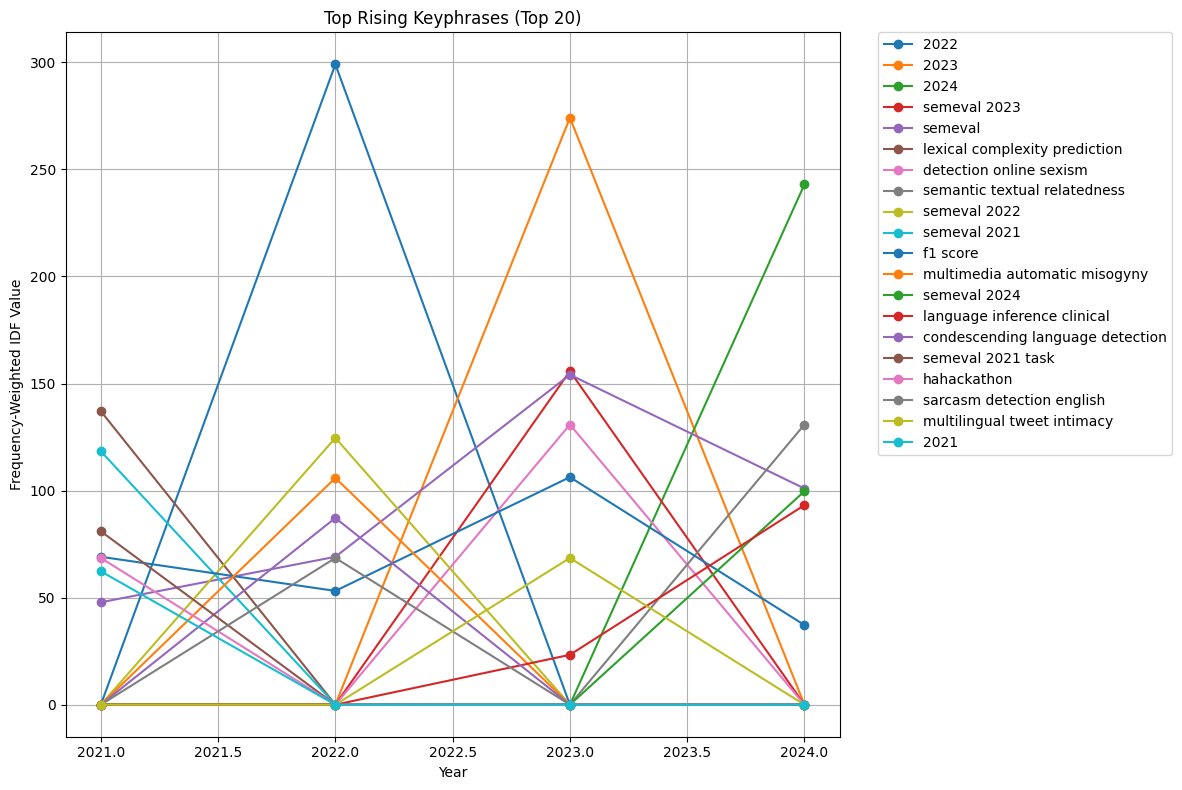

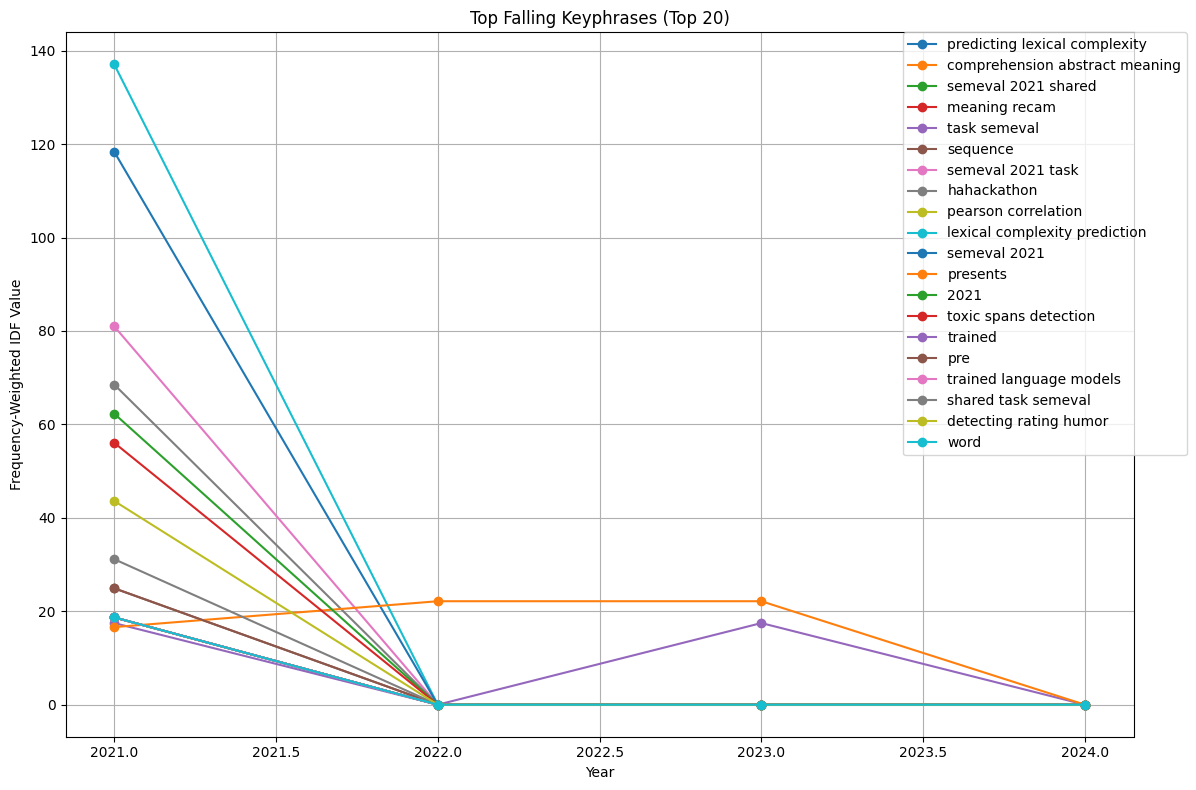

In [13]:
from keybert import KeyBERT
import json
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.corpus import stopwords
import string

# Initialize KeyBERT
kw_model = KeyBERT()

# Define the files and their associated years
file_year_mapping = {
    "papers-semeval-2021.json": 2021,
    "papers-semeval-2022.json": 2022,
    "papers-semeval-2023.json": 2023,
    "papers-semeval-2024.json": 2024,
}

# Load abstracts by year
abstracts_by_year = defaultdict(list)
for file, year in file_year_mapping.items():
    with open(file, "r", encoding="utf-8") as f:
        papers = json.load(f)
        abstracts = [paper["abstract"] for paper in papers if paper.get("abstract")]
        abstracts_by_year[year] = abstracts

# Load stop words
stop_words = set(stopwords.words("english"))

# Extract keyphrases with filtering
def extract_keyphrases_with_keybert(abstracts, top_n=10):
    all_phrases = []
    for abstract in abstracts:
        keyphrases = kw_model.extract_keywords(abstract, keyphrase_ngram_range=(1, 3), top_n=top_n, use_mmr=True, diversity=0.7)
        filtered_phrases = []
        for phrase, _ in keyphrases:
            phrase_tokens = phrase.lower().split()
            if any(token in stop_words or token in string.punctuation for token in phrase_tokens):
                continue
            filtered_phrases.append(phrase)
        all_phrases.extend(filtered_phrases)
    return all_phrases

# Extract keyphrases per year
keyphrases_by_year = defaultdict(list)
for year, abstracts in abstracts_by_year.items():
    keyphrases = extract_keyphrases_with_keybert(abstracts)
    keyphrases_by_year[year] = keyphrases
    print(f"Year {year}: {len(keyphrases)} keyphrases extracted")

# Calculate term frequency per document
def calculate_term_frequencies(keyphrases):
    term_frequencies = defaultdict(int)
    for phrase in keyphrases:
        term_frequencies[phrase] += 1
    return term_frequencies

# Calculate normalized frequencies (filter low-frequency terms)
def calculate_normalized_frequencies(keyphrases_by_year, min_frequency=3):
    normalized_freq = {}
    for year, keyphrases in keyphrases_by_year.items():
        term_frequencies = calculate_term_frequencies(keyphrases)
        filtered_frequencies = {phrase: freq for phrase, freq in term_frequencies.items() if freq >= min_frequency}
        normalized_freq[year] = filtered_frequencies
    return normalized_freq

normalized_freq = calculate_normalized_frequencies(keyphrases_by_year)

# Calculate IDF values
def calculate_idf(normalized_freq, total_docs):
    # Count documents where each phrase appears
    doc_count = defaultdict(int)
    for year, term_frequencies in normalized_freq.items():
        for phrase in term_frequencies.keys():
            doc_count[phrase] += 1

    # Compute IDF for each phrase
    idf = {phrase: math.log(total_docs / (count + 1)) for phrase, count in doc_count.items()}
    return idf

# Total number of documents
total_docs = sum(len(abstracts) for abstracts in abstracts_by_year.values())
idf = calculate_idf(normalized_freq, total_docs)

# Calculate IDF trends
def calculate_idf_trends(normalized_freq, idf):
    trends = defaultdict(list)
    years = sorted(normalized_freq.keys())

    for phrase in idf.keys():
        for year in years:
            # Calculate frequency-weighted IDF for the phrase in each year
            freq = normalized_freq[year].get(phrase, 0)
            phrase_idf = idf.get(phrase, 0) * freq if freq > 0 else 0
            trends[phrase].append((year, phrase_idf))

    return trends

trends = calculate_idf_trends(normalized_freq, idf)

# Plot IDF trends
def plot_idf_trends(trends, title, top_n=10, rising=True):
    sorted_trends = sorted(
        trends.items(),
        key=lambda x: max(change[1] if rising else -change[1] for change in x[1]),
        reverse=True
    )
    top_phrases = [phrase for phrase, _ in sorted_trends[:top_n]]

    plt.figure(figsize=(12, 8))
    for phrase in top_phrases:
        changes = trends.get(phrase, [])
        years, idf_values = zip(*changes)
        plt.plot(years, idf_values, marker='o', label=phrase)

    plt.title(f"{title} (Top {top_n})")
    plt.xlabel("Year")
    plt.ylabel("Frequency-Weighted IDF Value")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot top rising and falling trends separately
plot_idf_trends(trends, "Top Rising Keyphrases", top_n=20, rising=True)
plot_idf_trends(trends, "Top Falling Keyphrases", top_n=20, rising=False)


In [5]:
# Plot trends for a larger number of phrases directly from the trends dictionary
def plot_extended_trends(trends, title, top_n=20):
    # Sort phrases by the total frequency change (sum of absolute differences across years)
    sorted_trends = sorted(
        trends.items(),
        key=lambda x: sum(abs(change[1]) for change in x[1]),
        reverse=True
    )
    
    # Extract the top_n phrases for plotting
    top_phrases = [phrase for phrase, _ in sorted_trends[:top_n]]
    
    # Plot the trends
    plt.figure(figsize=(12, 8))
    for phrase in top_phrases:
        changes = trends.get(phrase, [])
        if changes:
            # Include all 4 years in the x-axis
            years, values = zip(*changes)
            all_years = [2021, 2022, 2023, 2024]
            all_values = [0] * len(all_years)
            for year, value in changes:
                all_values[all_years.index(year)] = value
            plt.plot(all_years, all_values, marker='o', label=phrase)
    plt.title(f"{title} (Top {top_n})")
    plt.xlabel("Year")
    plt.ylabel("Frequency Change")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot extended trends for rising and falling phrases
plot_extended_trends(trends, "Top Rising and Falling Keyphrases (Top 20)", top_n=20)


NameError: name 'trends' is not defined

Year 2021: 21276 keyphrases extracted
Year 2022: 25966 keyphrases extracted
Year 2023: 36941 keyphrases extracted
Year 2024: 33828 keyphrases extracted


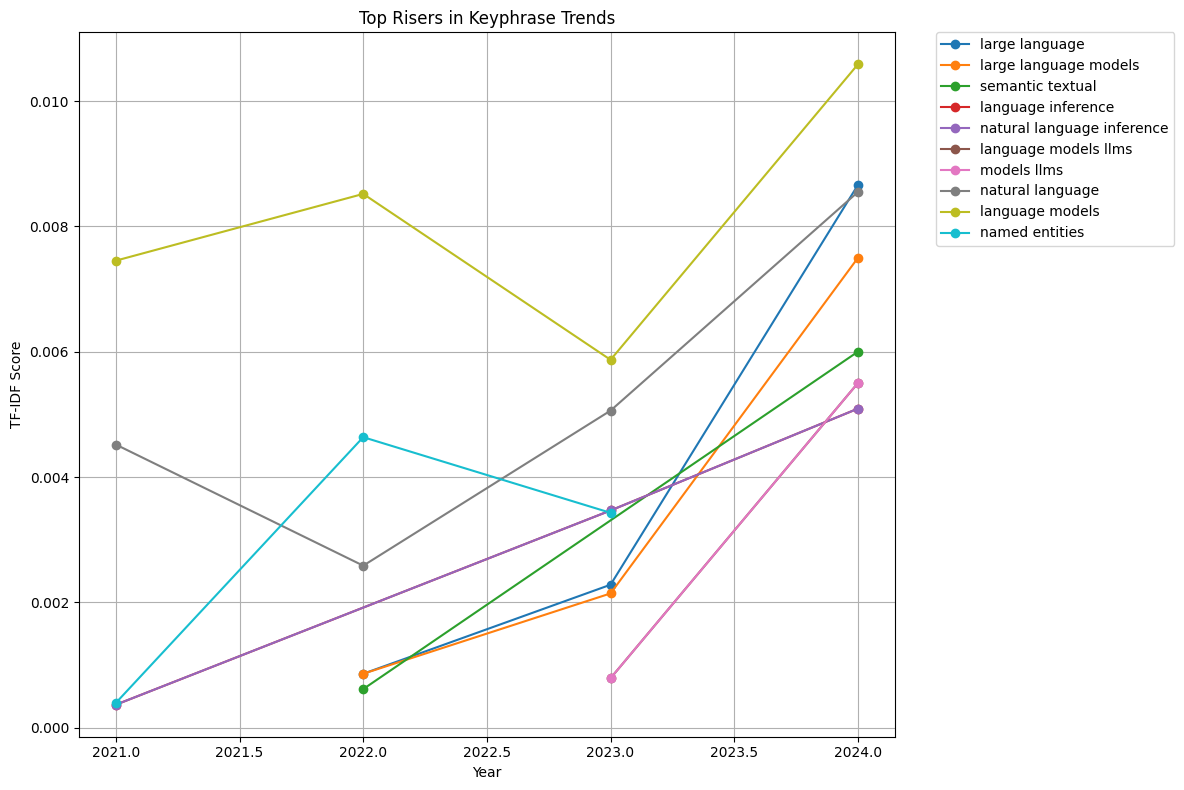

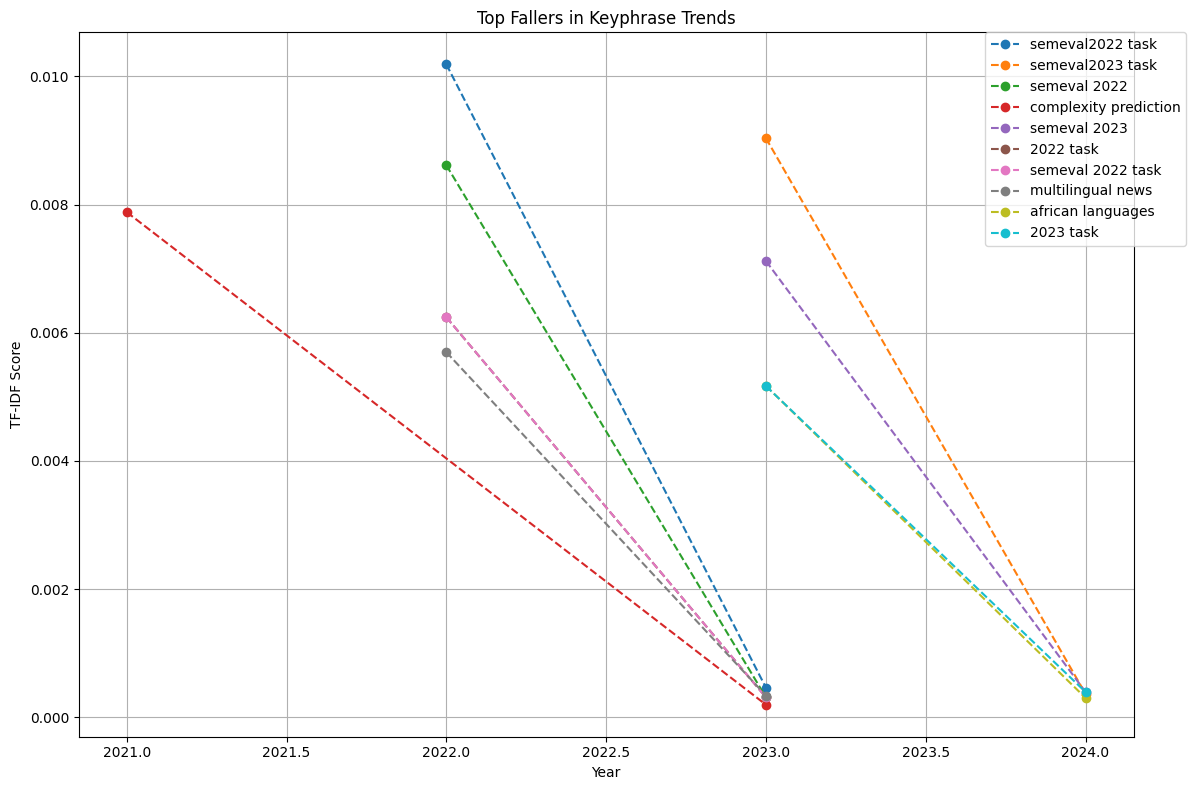

In [4]:
from keybert import KeyBERT
import json
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# Define the files and their associated years
file_year_mapping = {
    "papers-semeval-2021.json": 2021,
    "papers-semeval-2022.json": 2022,
    "papers-semeval-2023.json": 2023,
    "papers-semeval-2024.json": 2024,
}

# Load abstracts by year
abstracts_by_year = defaultdict(list)
for file, year in file_year_mapping.items():
    with open(file, "r", encoding="utf-8") as f:
        papers = json.load(f)
        abstracts = [paper["abstract"] for paper in papers if paper.get("abstract")]
        abstracts_by_year[year] = abstracts

# Preprocess text
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Extract keyphrases using TF-IDF
def extract_keyphrases_tfidf(abstracts):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(abstracts)
    feature_names = vectorizer.get_feature_names_out()

    # Calculate mean TF-IDF score for each term
    tfidf_scores = tfidf_matrix.mean(axis=0).A1
    term_scores = [(feature_names[i], tfidf_scores[i]) for i in range(len(feature_names))]
    term_scores = sorted(term_scores, key=lambda x: x[1], reverse=True)

    # Return all keyphrases with scores
    return term_scores

# Extract keyphrases per year
keyphrases_by_year = {}
all_keyphrases = defaultdict(list)
for year, abstracts in abstracts_by_year.items():
    processed_abstracts = [preprocess_text(abstract) for abstract in abstracts]
    keyphrase_scores = extract_keyphrases_tfidf(processed_abstracts)
    # Filter for multi-word keyphrases (at least two words)
    keyphrase_scores = [(term, score) for term, score in keyphrase_scores if len(term.split()) >= 2]
    keyphrases_by_year[year] = keyphrase_scores
    for term, score in keyphrase_scores:
        all_keyphrases[term].append((year, score))
    print(f"Year {year}: {len(keyphrase_scores)} keyphrases extracted")

# Aggregate statistics on keyphrases
def calculate_statistics(all_keyphrases):
    statistics = []
    for term, yearly_scores in all_keyphrases.items():
        total_score = sum(score for _, score in yearly_scores)
        avg_score = total_score / len(yearly_scores)
        first_year = min(year for year, _ in yearly_scores)
        last_year = max(year for year, _ in yearly_scores)
        statistics.append((term, total_score, avg_score, first_year, last_year))
    statistics = sorted(statistics, key=lambda x: x[1], reverse=True)
    return statistics

keyphrase_statistics = calculate_statistics(all_keyphrases)

# Identify rising and falling keyphrases
def identify_top_risers_and_fallers(all_keyphrases, top_n=10):
    trends = []
    for term, yearly_scores in all_keyphrases.items():
        yearly_scores = sorted(yearly_scores, key=lambda x: x[0])  # Sort by year
        if len(yearly_scores) > 1:
            first_score = yearly_scores[0][1]
            last_score = yearly_scores[-1][1]
            score_diff = last_score - first_score
            trends.append((term, score_diff))

    risers = sorted(trends, key=lambda x: x[1], reverse=True)[:top_n]
    fallers = sorted(trends, key=lambda x: x[1])[:top_n]

    return risers, fallers

risers, fallers = identify_top_risers_and_fallers(all_keyphrases)

# Plot risers
def plot_risers(risers, title):
    plt.figure(figsize=(12, 8))
    for term, _ in risers:
        yearly_scores = all_keyphrases[term]
        years, scores = zip(*sorted(yearly_scores, key=lambda x: x[0]))
        plt.plot(years, scores, marker='o', label=term)

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("TF-IDF Score")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot fallers
def plot_fallers(fallers, title):
    plt.figure(figsize=(12, 8))
    for term, _ in fallers:
        yearly_scores = all_keyphrases[term]
        years, scores = zip(*sorted(yearly_scores, key=lambda x: x[0]))
        plt.plot(years, scores, marker='o', linestyle='--', label=term)

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("TF-IDF Score")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot top risers and fallers separately
plot_risers(risers, "Top Risers in Keyphrase Trends")
plot_fallers(fallers, "Top Fallers in Keyphrase Trends")


5 keywordi keybertiga, 200 klastrit, top 20 fallers risers on suht ok tulemus

Year 2021: 928 keyphrases extracted
Year 2022: 1157 keyphrases extracted
Year 2023: 1582 keyphrases extracted
Year 2024: 1386 keyphrases extracted


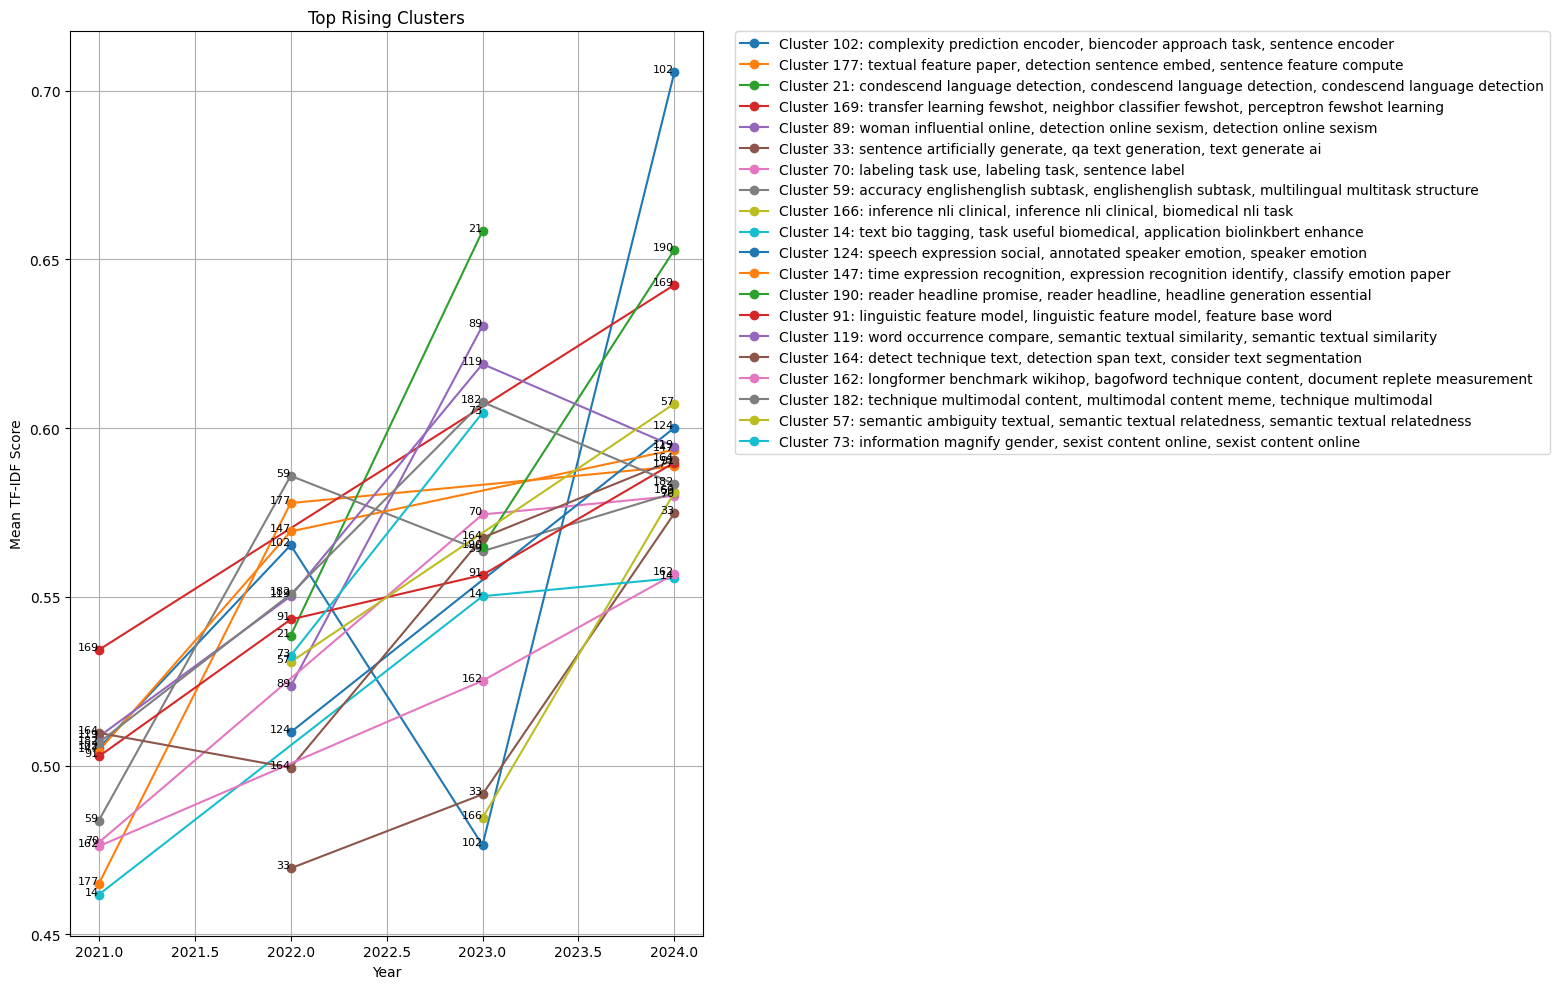

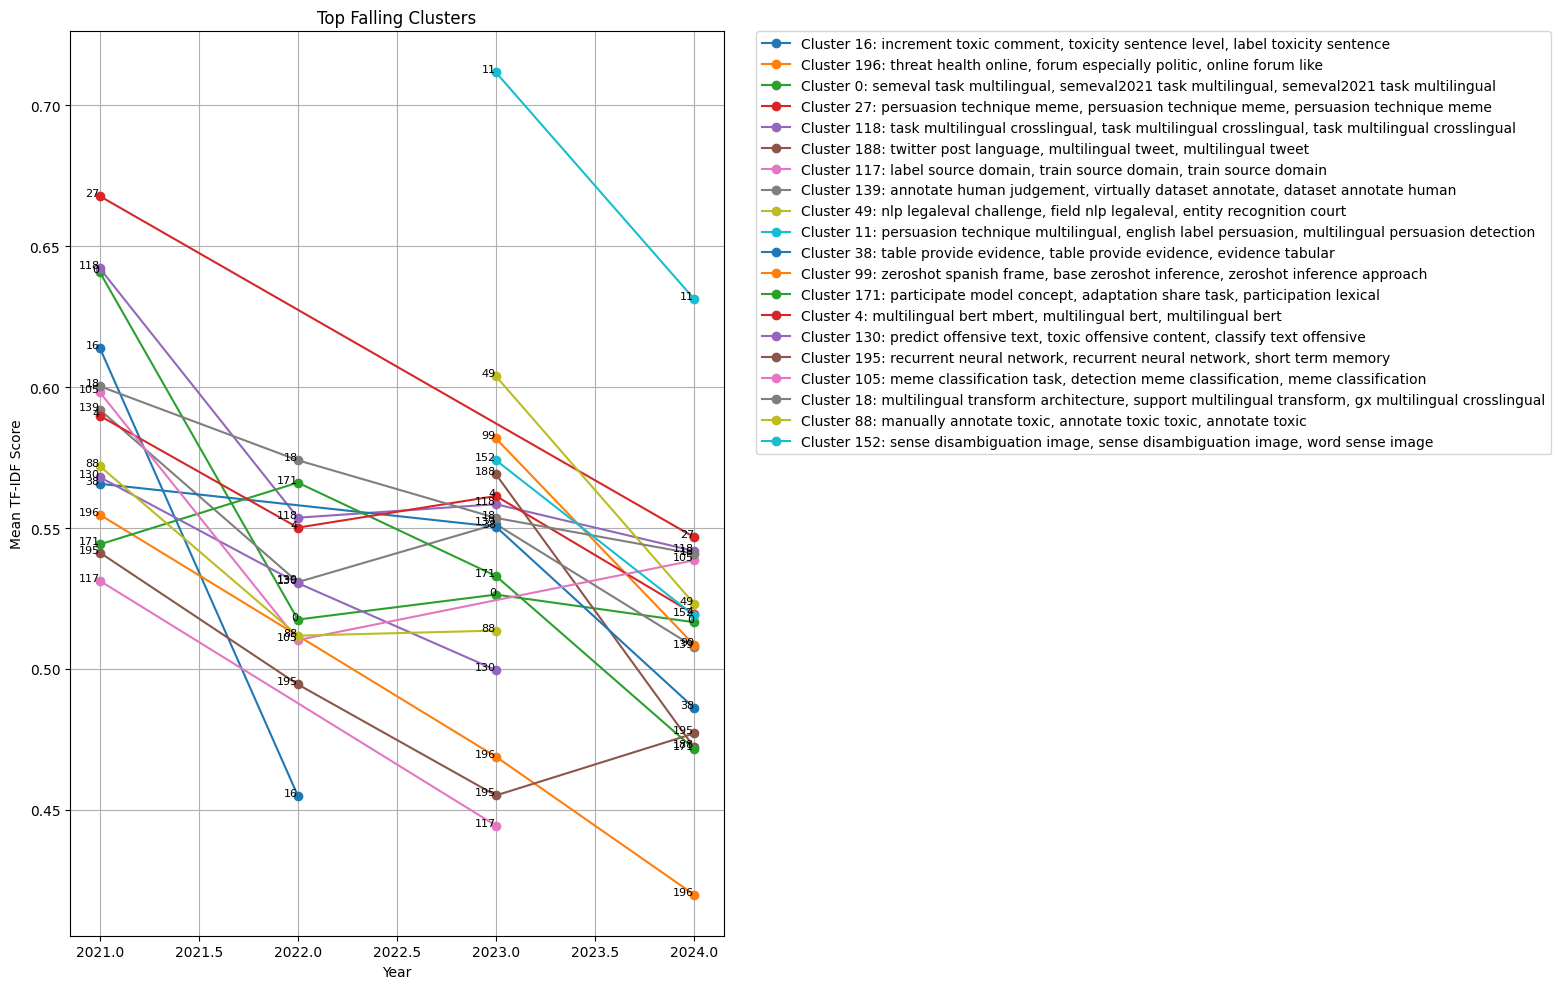

In [24]:
from keybert import KeyBERT
import json
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import string
import numpy as np
import spacy

# Load spacy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Define the files and their associated years
file_year_mapping = {
    "papers-semeval-2021.json": 2021,
    "papers-semeval-2022.json": 2022,
    "papers-semeval-2023.json": 2023,
    "papers-semeval-2024.json": 2024,
}

# Load abstracts by year
abstracts_by_year = defaultdict(list)
for file, year in file_year_mapping.items():
    with open(file, "r", encoding="utf-8") as f:
        papers = json.load(f)
        abstracts = [paper["abstract"] for paper in papers if paper.get("abstract")]
        abstracts_by_year[year] = abstracts

# Preprocess text with lemmatization
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    doc = nlp(text)
    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized

# Extract keyphrases using TF-IDF
def extract_keyphrases_tfidf(abstracts):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(abstracts)
    feature_names = vectorizer.get_feature_names_out()

    # Calculate mean TF-IDF score for each term
    tfidf_scores = tfidf_matrix.mean(axis=0).A1
    term_scores = [(feature_names[i], tfidf_scores[i]) for i in range(len(feature_names))]
    term_scores = sorted(term_scores, key=lambda x: x[1], reverse=True)

    # Return all keyphrases with scores
    return term_scores

kw_model = KeyBERT()

# Extract keyphrases using KeyBERT
def extract_keyphrases_keybert(abstracts, top_n=5):
    all_phrases = []
    for abstract in abstracts:
        keyphrases = kw_model.extract_keywords(abstract, keyphrase_ngram_range=(1, 3), top_n=top_n)
        all_phrases.extend(keyphrases)  # Keyphrases is a list of (phrase, score)
    return all_phrases



# Extract keyphrases per year
keyphrases_by_year = {}
all_keyphrases = defaultdict(list)
for year, abstracts in abstracts_by_year.items():
    processed_abstracts = [preprocess_text(abstract) for abstract in abstracts]
    keyphrase_scores = extract_keyphrases_keybert(processed_abstracts)
    # Filter for multi-word keyphrases (at least two words)
    keyphrase_scores = [(term, score) for term, score in keyphrase_scores if len(term.split()) >= 2]
    keyphrases_by_year[year] = keyphrase_scores
    for term, score in keyphrase_scores:
        all_keyphrases[term].append((year, score))
    print(f"Year {year}: {len(keyphrase_scores)} keyphrases extracted")

# Embed keyphrases using Sentence-BERT
def embed_keyphrases(keyphrases):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode([term for term, _ in keyphrases])
    return embeddings

# Cluster keyphrases
def cluster_keyphrases(embeddings, keyphrases, n_clusters=50):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    clustered_keyphrases = defaultdict(list)
    for label, (term, score) in zip(labels, keyphrases):
        clustered_keyphrases[label].append((term, score))

    return clustered_keyphrases

# Analyze clustered trends
def analyze_clustered_trends(clustered_keyphrases, all_keyphrases):
    trends = {}
    for cluster, phrases in clustered_keyphrases.items():
        cluster_scores = defaultdict(list)
        for term, _ in phrases:
            if term in all_keyphrases:
                for year, score in all_keyphrases[term]:
                    cluster_scores[year].append(score)

        # Aggregate scores by year
        aggregated_scores = {year: np.mean(scores) for year, scores in cluster_scores.items()}
        trends[cluster] = aggregated_scores

    return trends

# Identify top risers and fallers by cluster
def identify_risers_and_fallers(clustered_trends, clustered_keyphrases, top_n=20):
    trend_changes = []
    for cluster, trends in clustered_trends.items():
        years = sorted(trends.keys())
        if len(years) > 1:
            change = trends[years[-1]] - trends[years[0]]
            trend_changes.append((cluster, change))

    risers = sorted(trend_changes, key=lambda x: x[1], reverse=True)[:top_n]
    fallers = sorted(trend_changes, key=lambda x: x[1])[:top_n]

    def get_representative_terms(cluster):
        terms = [term for term, _ in clustered_keyphrases[cluster]]
        return ", ".join(terms[:3])  # Top 3 representative terms

    return [(cluster, change, get_representative_terms(cluster)) for cluster, change in risers], \
           [(cluster, change, get_representative_terms(cluster)) for cluster, change in fallers]

# Plot top risers or fallers
def plot_cluster_trends(clusters, clustered_trends, title):
    plt.figure(figsize=(16, 10))  # Adjusted for wider plots
    for cluster, _, representative_terms in clusters:
        trends = clustered_trends[cluster]
        years = sorted(trends.keys())
        scores = [trends[year] for year in years]
        plt.plot(years, scores, marker='o', label=f"Cluster {cluster}: {representative_terms}")
        for year, score in zip(years, scores):
            plt.text(year, score, str(cluster), fontsize=8, ha='right')

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Mean TF-IDF Score")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Embed all keyphrases and cluster
all_keyphrase_list = [(term, score) for term, scores in all_keyphrases.items() for year, score in scores]
embeddings = embed_keyphrases(all_keyphrase_list)
clustered_keyphrases = cluster_keyphrases(embeddings, all_keyphrase_list, n_clusters=200)
clustered_trends = analyze_clustered_trends(clustered_keyphrases, all_keyphrases)

# Identify risers and fallers
risers, fallers = identify_risers_and_fallers(clustered_trends, clustered_keyphrases)

# Plot top risers and fallers
plot_cluster_trends(risers, clustered_trends, "Top Rising Clusters")
plot_cluster_trends(fallers, clustered_trends, "Top Falling Clusters")
